
Running simulation with Hungarian algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:00<00:00, 174.05it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 1774
Total Cancelled Rides: 663
Cancellation Rate: 27.21%
Average Waiting Time: 283.50 seconds
Average Trip Time: 959.54 seconds
Average Driver Earnings: $13.33
Average Empty Miles: 0.68 miles
Driver Earnings Gini Coefficient: 0.1930

Running simulation with Stable Matching algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:04<00:00, 26.63it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 1780
Total Cancelled Rides: 657
Cancellation Rate: 26.96%
Average Waiting Time: 289.72 seconds
Average Trip Time: 953.03 seconds
Average Driver Earnings: $13.31
Average Empty Miles: 0.71 miles
Driver Earnings Gini Coefficient: 0.1950


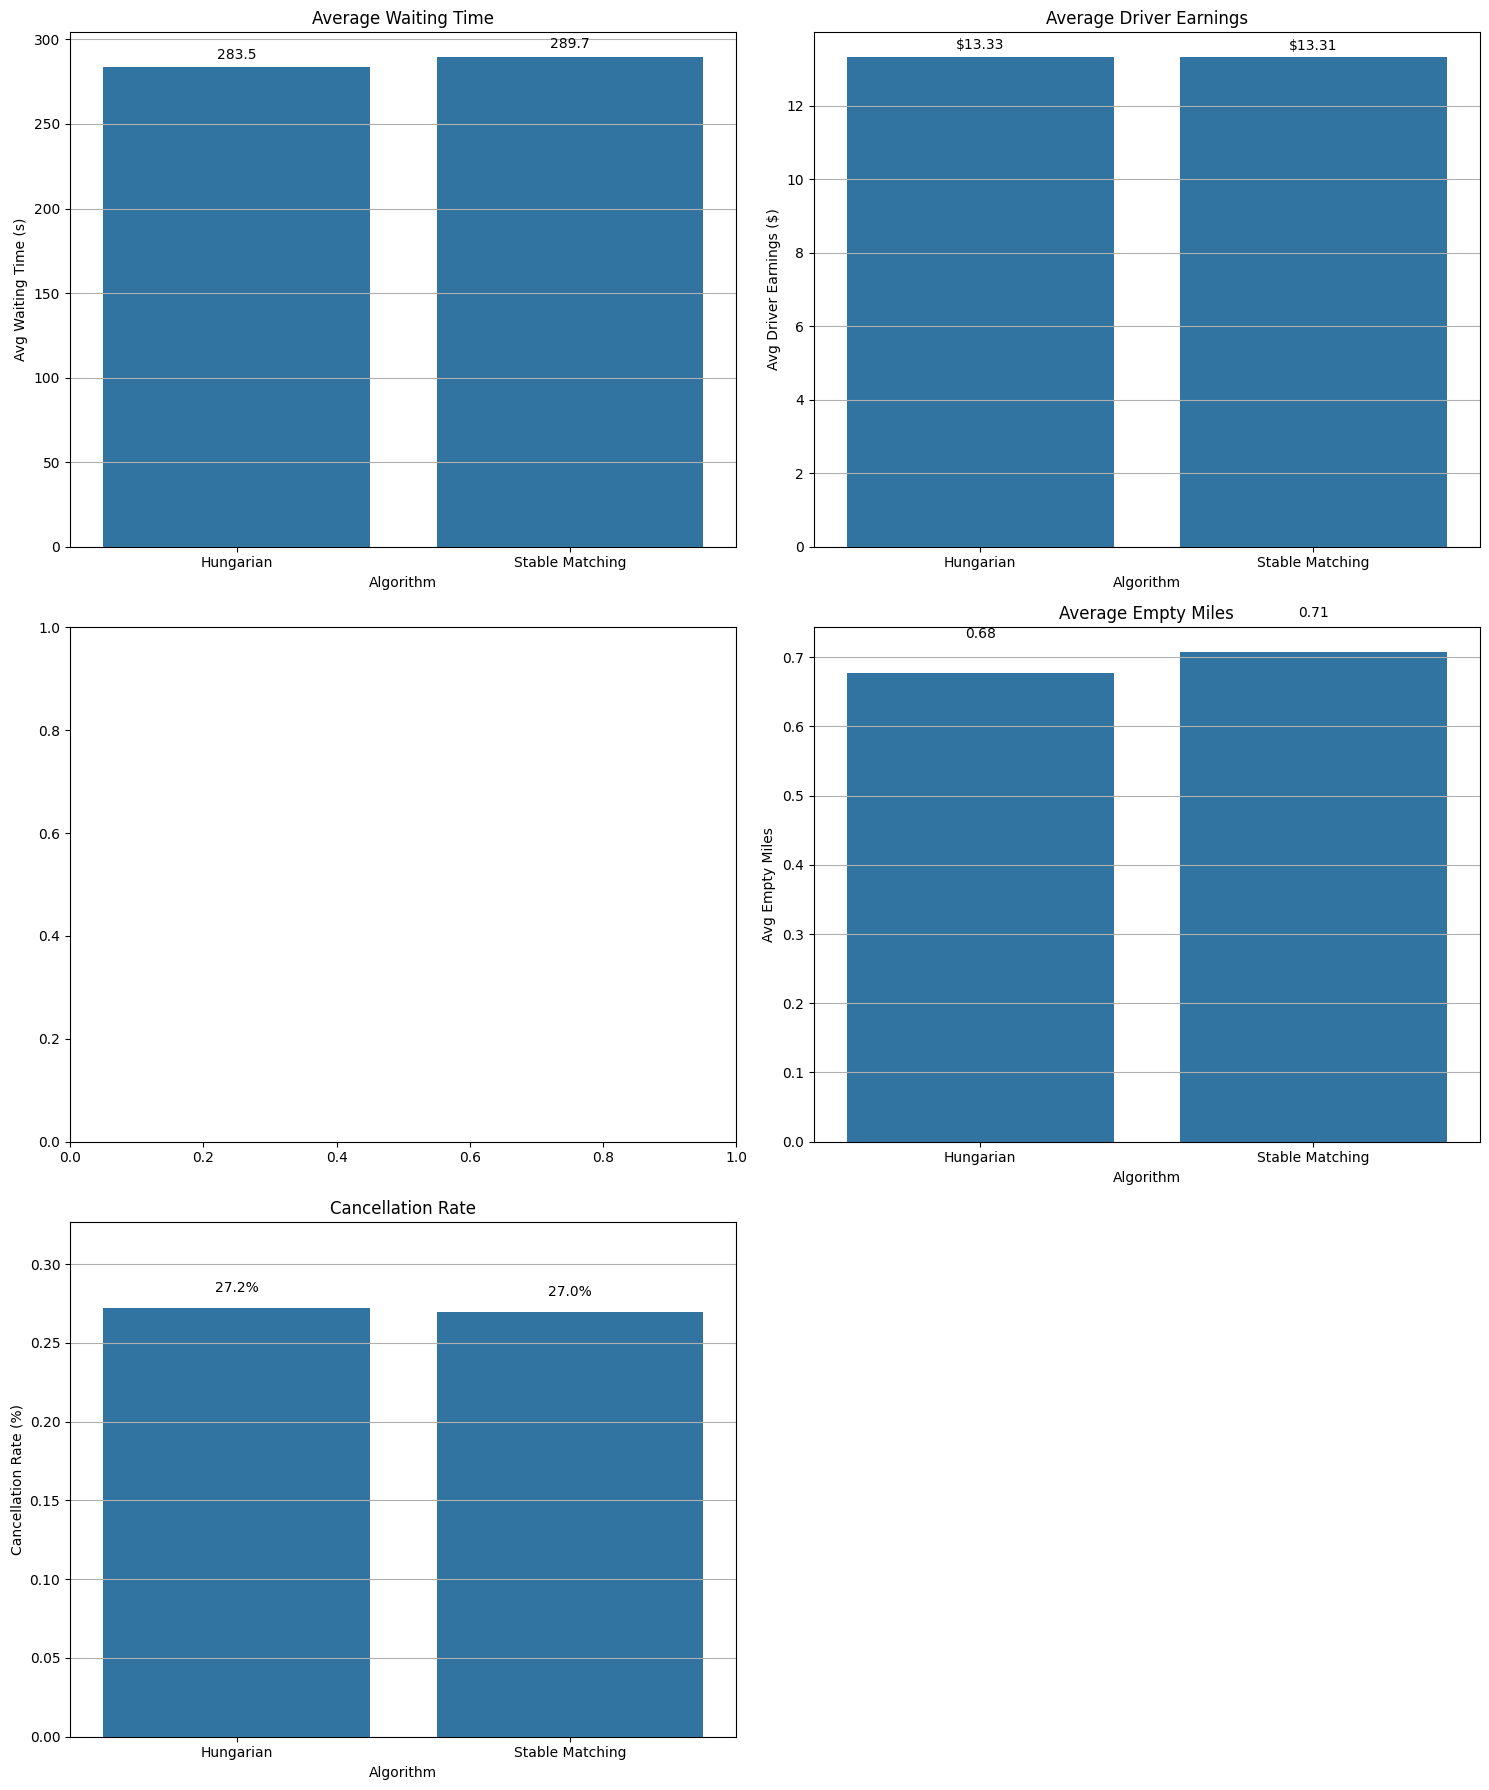


Algorithm Comparison Summary:
-----------------------------
total_completed_trips: Hungarian: 1774.00, Stable Matching: 1780.00
total_cancelled_rides: Hungarian: 663.00, Stable Matching: 657.00
cancellation_rate: Hungarian: 0.2721, Stable Matching: 0.2696
avg_waiting_time: Hungarian: 283.50, Stable Matching: 289.72
avg_trip_time: Hungarian: 959.54, Stable Matching: 953.03
avg_driver_earnings: Hungarian: 13.33, Stable Matching: 13.31
avg_empty_miles: Hungarian: 0.68, Stable Matching: 0.71
gini_coefficient: Hungarian: 0.1930, Stable Matching: 0.1950
runtime_seconds: Hungarian: 0.70s, Stable Matching: 4.51s


In [1]:
from algorithms import *
from models import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from enviroments import *
import random

def run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date):
    """
    Run comparison of different matching algorithms with consistent driver initialization
    
    Args:
        trip_data_path: Path to trip data
        zone_data_path: Path to zone data
        start_date: Simulation start date
        end_date: Simulation end date
    """
    city = City(zone_data_path)
    trip_df = pd.read_parquet(trip_data_path)
    city.central_zone_id = trip_df['PULocationID'].value_counts().idxmax()
    
    # Define algorithms to test
    algorithms = [
        # ('Greedy Nearest', GreedyNearestNeighbor()),
        ('Hungarian', BatchedHungarianAlgorithm()),
        ('Stable Matching', StableMatchingAlgorithm()),
        # ('RideShareing', SharedRideMatchingAlgorithm()),
        # ('Revenue Maximization Hungarian', RevenueMaximizingMatchingAlgorithm()),
    ]
    
    # Results storage
    all_metrics = []
    algorithm_names = []
    
    # ---------------------------------------
    # Generate consistent driver initialization
    # ---------------------------------------
    
    # Set random seed for reproducibility
    np.random.seed(2)
    random.seed(2)
    
    # Get distribution of pickup locations to place drivers
    NUM_DRIVERS = 1000  # Match the value used in Simulation
    
    # Pre-determine driver locations based on pickup distribution
    pickup_dist = trip_df['PULocationID'].value_counts(normalize=True)
    
    # Generate initial driver positions that will be reused
    initial_driver_locations = []
    for i in range(NUM_DRIVERS):
        driver_id = f"D{i:05d}"
        if len(pickup_dist) > 0:
            location_id = np.random.choice(pickup_dist.index, p=pickup_dist.values)
        else:
            location_id = np.random.choice(city.zones['LocationID'].values)
        initial_driver_locations.append((driver_id, location_id))
    
    # Save original driver initialization function
    original_init_drivers = Simulation._initialize_synthetic_drivers
    
    # Override driver initialization with our consistent version
    def consistent_driver_init(self, num_drivers):
        """Create drivers with consistent initial locations across algorithm runs"""
        # Use the pre-determined locations
        for driver_id, location_id in initial_driver_locations:
            self.drivers[driver_id] = Driver(driver_id, location_id)
            
    # Run simulations with each algorithm
    for name, algorithm in algorithms:
        print(f"\nRunning simulation with {name} algorithm...")
        
        # Temporarily override the driver initialization method
        Simulation._initialize_synthetic_drivers = consistent_driver_init
        
        # Initialize simulation
        sim = Simulation(city, algorithm)
        sim.initialize_from_data(
            driver_data_path=None,  # Using synthetic drivers with consistent initialization
            trip_data_path=trip_data_path,
            start_date=start_date,
            end_date=end_date,
            batch_interval_minutes=1,
            max_wait_time_minutes=10,
            num_drivers=NUM_DRIVERS,
        )
        
        # Run simulation and time it
        start_time = time.time()
        sim.run()
        duration = time.time() - start_time
        
        # Store results
        metrics = sim.metrics.copy()
        metrics['runtime_seconds'] = duration
        all_metrics.append(metrics)
        algorithm_names.append(name)
    
    # Restore original driver initialization function
    Simulation._initialize_synthetic_drivers = original_init_drivers
        
    # Compare results
    analyzer = SimulationAnalyzer(sim)  # Use last simulation for analyzer
    analyzer.plot_metrics_comparison(all_metrics, algorithm_names)
    plt.show()
    
    # Additional comparison of key metrics
    print("\nAlgorithm Comparison Summary:")
    print("-----------------------------")
    comparison_df = pd.DataFrame(all_metrics, index=algorithm_names)
    
    # Format and display key metrics
    metrics_to_show = [
        'total_completed_trips', 'total_cancelled_rides', 'cancellation_rate',
        'avg_waiting_time', 'avg_trip_time', 'avg_driver_earnings', 
        'avg_empty_miles', 'gini_coefficient', 'runtime_seconds'
    ]
    
    for metric in metrics_to_show:
        if metric in comparison_df.columns:
            if metric in ['cancellation_rate', 'gini_coefficient']:
                print(f"{metric}: {', '.join([f'{name}: {val:.4f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            elif metric == 'runtime_seconds':
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}s' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            else:
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")


def main():
    # Example paths - replace with actual paths
    trip_data_path = "../data/sample.parquet"
    zone_data_path = "../data/taxi_zones/taxi_zones.shp"
    
    # Define simulation period
    start_date = datetime(2025, 1, 1, 8, 0, 0)  # 8 AM on January 1, 2025
    end_date = datetime(2025, 1, 1, 10, 0, 0)   # 8:30 PM on January 1, 2025
    
    # Run comparison
    run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date)


if __name__ == "__main__":
    main()